In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from tqdm.notebook import tqdm

In [2]:
import sys, os
sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2

from modules.config import *
from modules.preprocessing import calculate_availability

# Availability Aggregation
In this notebook we will calculate the availability of each hexagon at each time interval.
The availability is defined as the number of vehicles that are (at some point) in the hexagon during a given time interval.


For this purpose, we follow the following algorithm:
1. We set the availability of a given hexagon at a given time interval to the number of bicycles whose first seen locations are in that hexagon.  
2. We update the availability of the hexagons with each trip and relocation by subtracting from the availability in the starting hexagon and adding to the end hexagon.
3. When a bicycle reaches its final location, it is subtracted from the availability.

Following this algorithm the availability can be expressed more formally as
$$A(h, t) = A(h, t-1) + s_t(h) - d_t(h) \delta_t^+(h) - \delta_t^-(h)$$
where $A(h, t)$ describes the total number of available bicycles at hexagon $h$ at time interval $t$,  
$\delta_t^+(h)$ and $\delta_t^-(h)$ describe the total number of incoming and outgoing trips and relocations in time interval $t$ considering hexagon $h$,  
$s_t(h)$ describes the number of bicycles that "spawn" (first observation) in hexagon $h$ at time interval $t$ and  
$d_t(h)$ describes the number of bicycles that "vanish" (last observation) in hexagon $h$ at time interval $t$.


**Note**: As a basis for our calculations we do not actually use the `trips` dataframe but the `movements` dataframe. The `movements` dataframe incorporates all movements of bicycles that we extracted from the original location data, e.g. also relocations.

In [3]:
movements_grouped = pd.read_parquet(MOVEMENTS_GROUPED_SPATIO_TEMPORAL_PATH)
movements = pd.read_parquet(MOVEMENTS_PATH)

In [4]:
movements_grouped = movements_grouped.rename({'demand': 'n_bikes'}, axis=1)
movements_grouped.head(2)

,datetime_start_floored,datetime_end_floored,start_hex_id,end_hex_id,n_bikes,h3_res,time_interval_length
0,2019-01-20,2019-01-20,871f1a164ffffff,871f1a164ffffff,2,7,1
1,2019-01-20,2019-01-20,871f1a164ffffff,871f1a8cbffffff,1,7,1


In [5]:
movements = movements.sort_values('datetime_start')
first_locations = movements.groupby('b_number').first().reset_index()
movements = movements.sort_values('datetime_end')
last_locations = movements.groupby('b_number').last().reset_index()

In [6]:
movements_grouped_spec = movements_grouped[
    (movements_grouped["h3_res"] == H3_RESOLUTION)
    & (movements_grouped["time_interval_length"] == TIME_INTERVAL_LENGTH)
]
movements_grouped_spec = movements_grouped_spec.drop(
    columns=["h3_res", "time_interval_length"]
)
movements_grouped_spec.head(2)


,datetime_start_floored,datetime_end_floored,start_hex_id,end_hex_id,n_bikes
0,2019-01-20,2019-01-20,881f1a1601fffff,881f1a1601fffff,4
1,2019-01-20,2019-01-20,881f1a1601fffff,881f1a1659fffff,3


In [7]:
first_locations = first_locations.rename(
    columns={"lat_start": "lat", "lng_start": "lng", "datetime_start": "datetime"}
)
# drop all except
last_locations = last_locations.rename(
    columns={"lat_end": "lat", "lng_end": "lng", "datetime_end": "datetime"}
)


In [8]:
availability = calculate_availability(
    movements_grouped_spec,
    first_locations,
    last_locations,
    H3_RESOLUTION,
    TIME_INTERVAL_LENGTH,
)


To check whether we did no mistakes, we will plot the availability over the whole time period. We should see that it starts at zero, then increases, then decreases and finally ends at zero.
It should never go below zero.

In [9]:
ar = availability.reset_index()

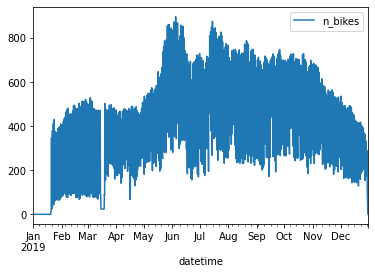

In [10]:
ar.groupby('datetime').sum().plot()
plt.show()

Now where we verified that our approach works, we will calculate the availability for each resolution and store the results in a single dataframe.

In [11]:
results = {}
for h3_res, time_interval_length in tqdm(
    list(itertools.product(CALC_H3_RESOLUTIONS, CALC_TIME_INTERVAL_LENGTHS))
):
    movements_grouped_spec = movements_grouped[
        (movements_grouped["h3_res"] == h3_res)
        & (movements_grouped["time_interval_length"] == time_interval_length)
    ]
    movements_grouped_spec = movements_grouped_spec.drop(
        columns=["h3_res", "time_interval_length"]
    )
    results[(h3_res, time_interval_length)] = calculate_availability(
        movements_grouped_spec,
        first_locations,
        last_locations,
        h3_res,
        time_interval_length,
    )


  0%|          | 0/12 [00:00<?, ?it/s]

In [12]:
availability = pd.concat(results)

In [13]:
availability.index.names = ['h3_res', 'time_interval_length', 'datetime', 'hex_id']

In [14]:
availability.head()

n_bikes
h3_res time_interval_length datetime   hex_id                  
7      1                    2019-01-01 871f1a140ffffff        0
                                       871f1a144ffffff        0
                                       871f1a145ffffff        0
                                       871f1a146ffffff        0
                                       871f1a160ffffff        0

In [15]:
availability.to_parquet(AVAILABILITY_PATH)